# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

PROJ: proj_create_from_database: Cannot find proj.db


Here we show that the calculated forward gravity of 2 sets of layers of absolute densities is identical to using the density contrasts across each surface.
<img src="../figures/absolute_vs_density_contrasts.png" width="500"/>

## Get sample data

Ice surface and bed from Bedmap2

returning grid with new region and/or registration, same spacing
returning grid with new region and/or registration, same spacing


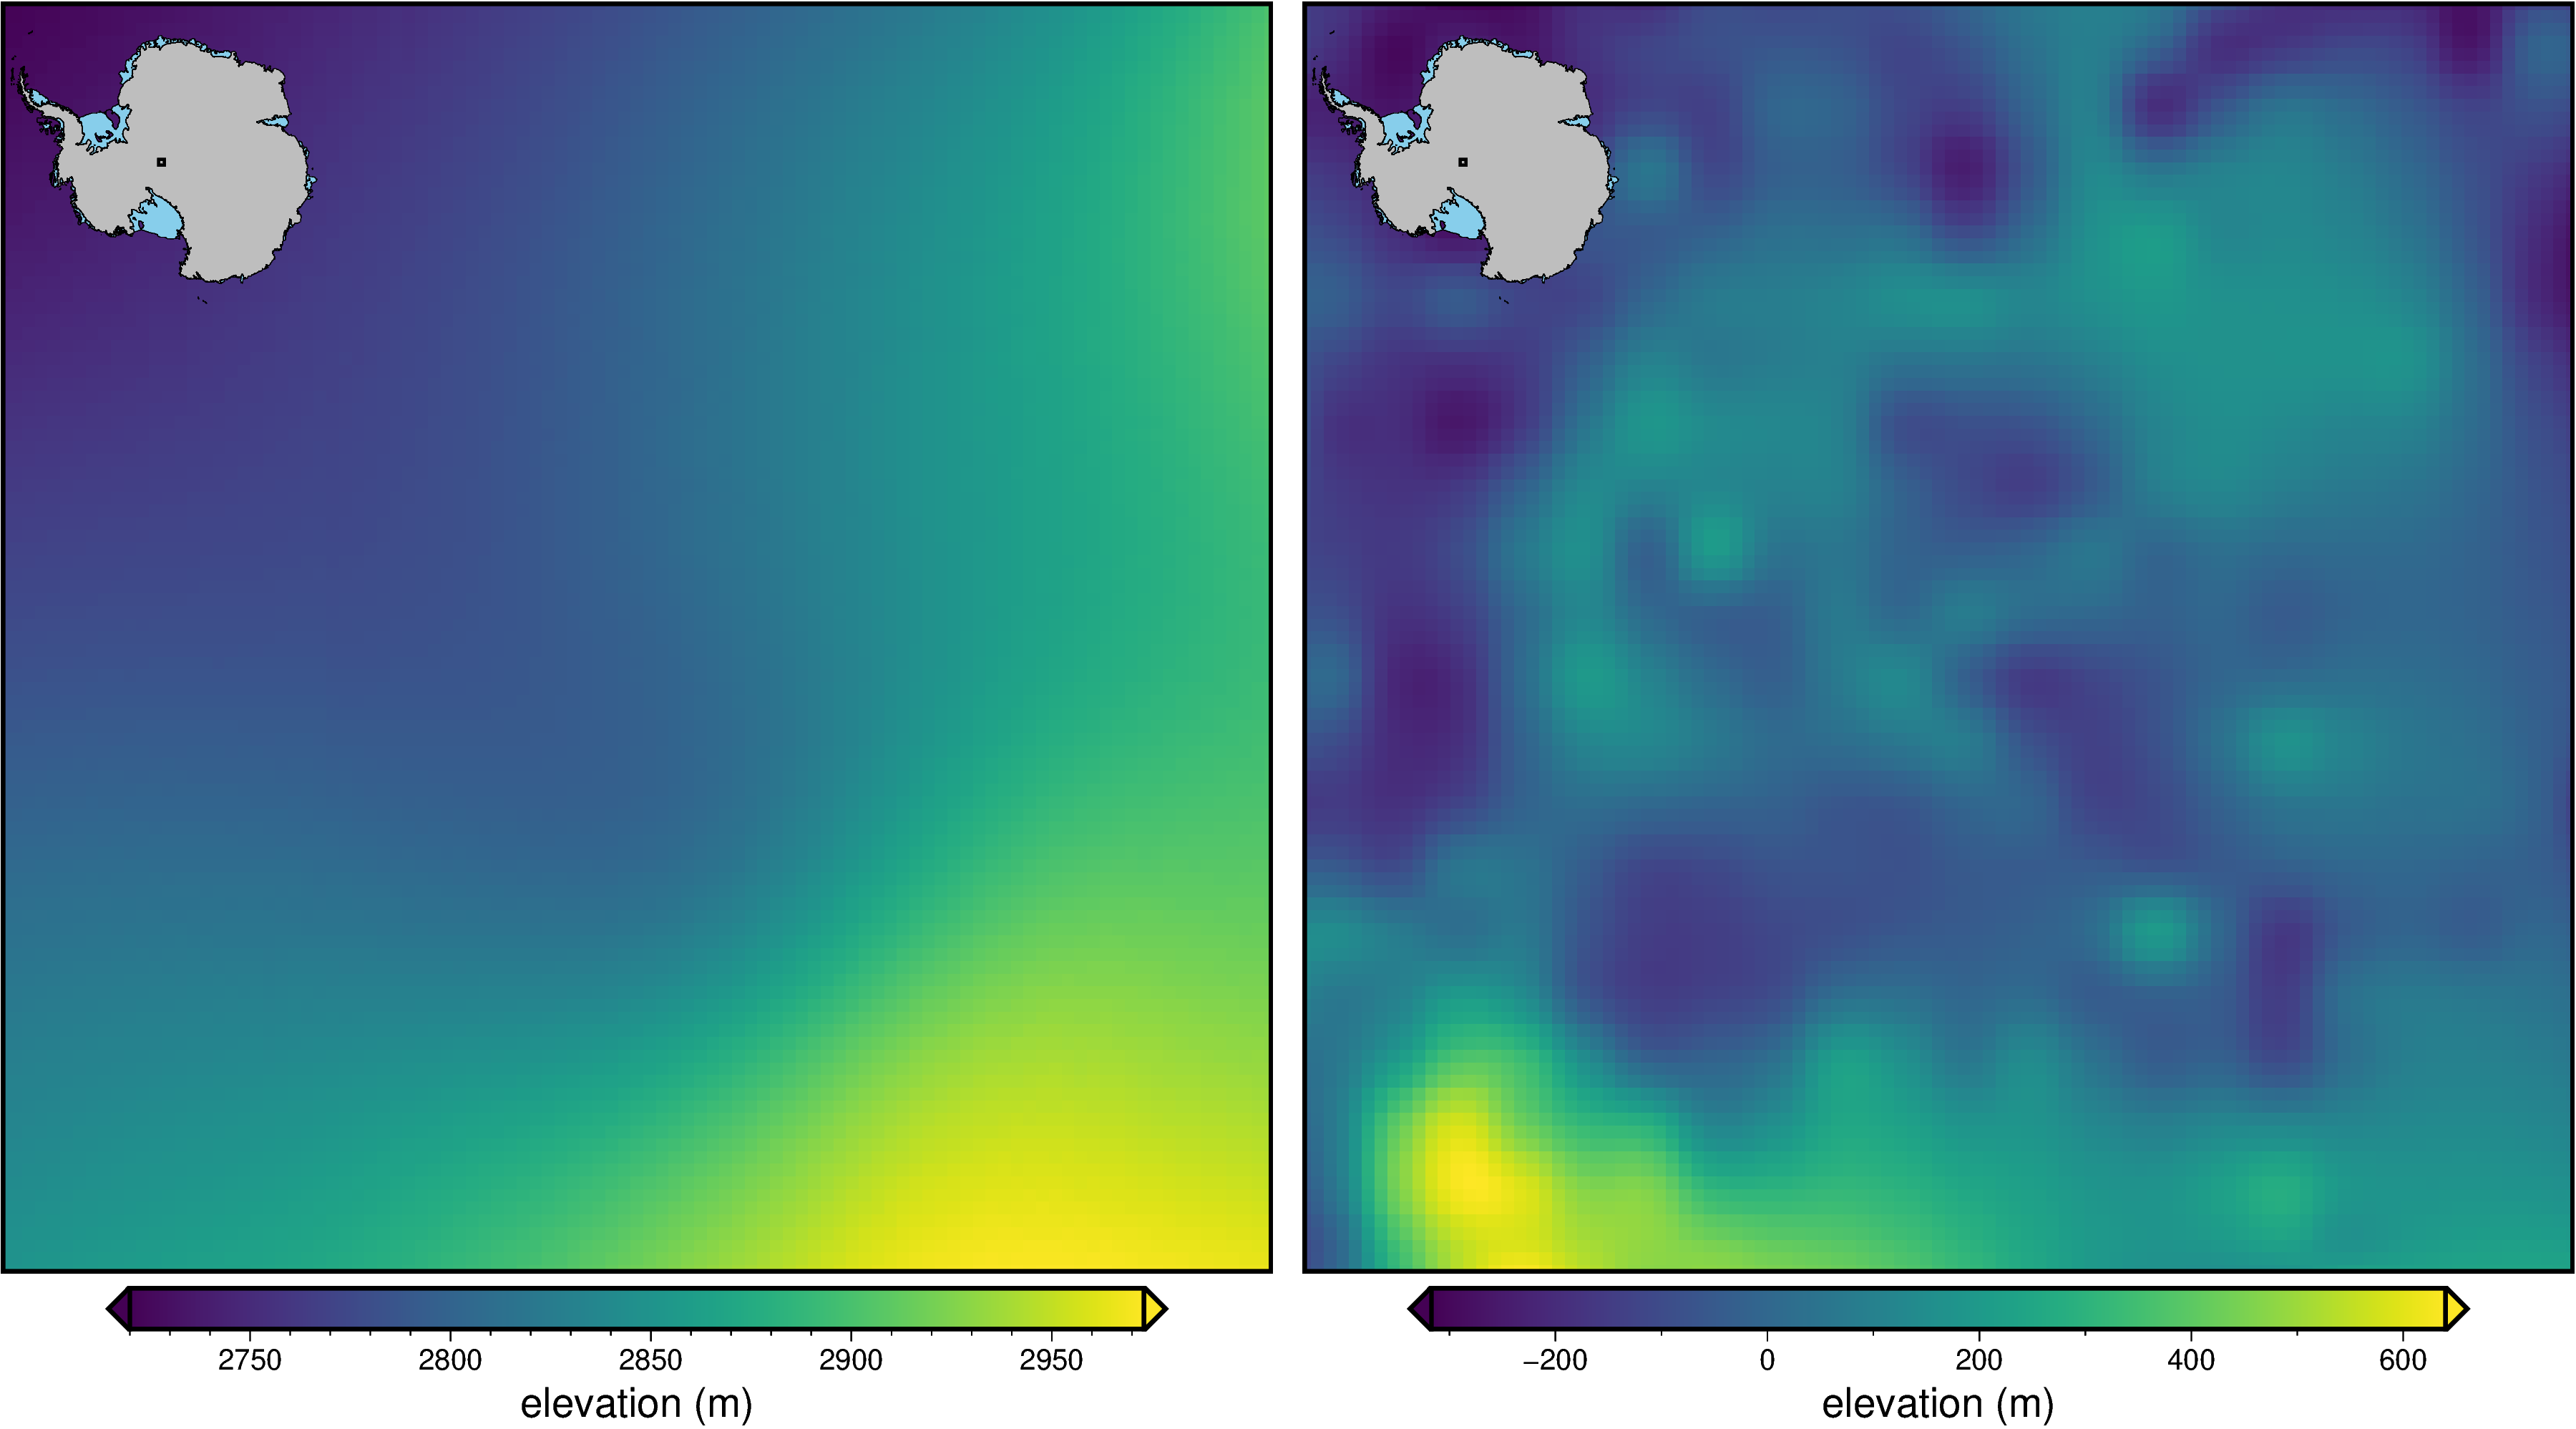

In [3]:
spacing = 1e3
region = [-50e3, 50e3, -50e3, 50e3]

surface = fetch.bedmap2(layer="surface", region=region, spacing=spacing)

bed = fetch.bedmap2(layer="bed", region=region, spacing=spacing)

fig = maps.plot_grd(
    surface,
    inset=True,
    titles="Surface",
    cbar_label="elevation (m)",
)

fig = maps.plot_grd(
    bed,
    inset=True,
    titles="Bed",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)
fig.show()

In [4]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Surface(
            z=surface.values,
            colorscale="Blues",
            opacity=1,  # 0.8,
            colorbar_x=0.8,
        ),
        go.Surface(
            z=bed.values,
            colorscale="Greens",
            opacity=0.9,
            colorbar_x=0.95,
        ),
    ],
)

camera = dict(eye=dict(x=1, y=1, z=1))

fig.update_layout(
    title="Ice and Bed",
    scene_aspectmode="manual",
    scene_aspectratio=dict(x=1, y=1, z=1),
)

fig.show()

## Useful functions

In [5]:
def grids_to_prisms(
    top: xr.DataArray,
    bottom: xr.DataArray,
    density,
    **kwargs,
):
    # if density provided as a single number, use it for all prisms
    if isinstance(density, (float, int)):
        dens = density * np.ones_like(top)
    # if density provided as a dataarray, map each density to the correct prisms
    elif isinstance(density, xr.DataArray):
        dens = density
    else:
        raise ValueError("invalid density type, should be a number or DataArray")

    # create layer of prisms based off input dataarrays
    prisms = hm.prism_layer(
        coordinates=(top.x.values, top.y.values),
        surface=top,
        reference=bottom,
        properties={
            "density": dens,
            "thickness": top - bottom,
        },
    )

    return prisms


def forward_grav_of_prismlayer(
    prisms: list,
    observation_points: tuple,
    plot: bool = True,
    **kwargs,
):
    grids = []
    for i, p in enumerate(prisms):
        grav = p.prism_layer.gravity(
            coordinates=observation_points,
            field="g_z",
            progressbar=True,
        )
        grav_grid = vd.make_xarray_grid(
            coordinates=observation_points,
            data=grav,
            data_names="grav",
            extra_coords_names="height",
        ).grav

        grids.append(grav_grid)

    def sum_list(l):
        total = 0
        for x in l:
            total += x
        return total

    if len(grids) > 1:
        total_forward = sum_list(grids)
        grids.append(total_forward)
        # grids.insert(0, total_forward)

    if plot is True:
        for i, g in enumerate(grids):
            if i == 0:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[0],
                    coast=True,
                )
            elif i == len(grids) - 1:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title="Total forward gravity",
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
            else:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[i],
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                )
        fig.show()

    return grids

## create observation points
with 25km buffer zone

In [7]:
observation_points = vd.grid_coordinates(
    utils.alter_region(region, zoom=25e3)[0],
    spacing=spacing,
    extra_coords=1200,
)

## Absolute Densities

In [6]:
ice_prisms = grids_to_prisms(
    surface,
    bed,
    density=917,
)

bed_prisms = grids_to_prisms(
    bed,
    bed.values.min(),
    density=2030,
)

plotting.show_prism_layers(
    [ice_prisms, bed_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


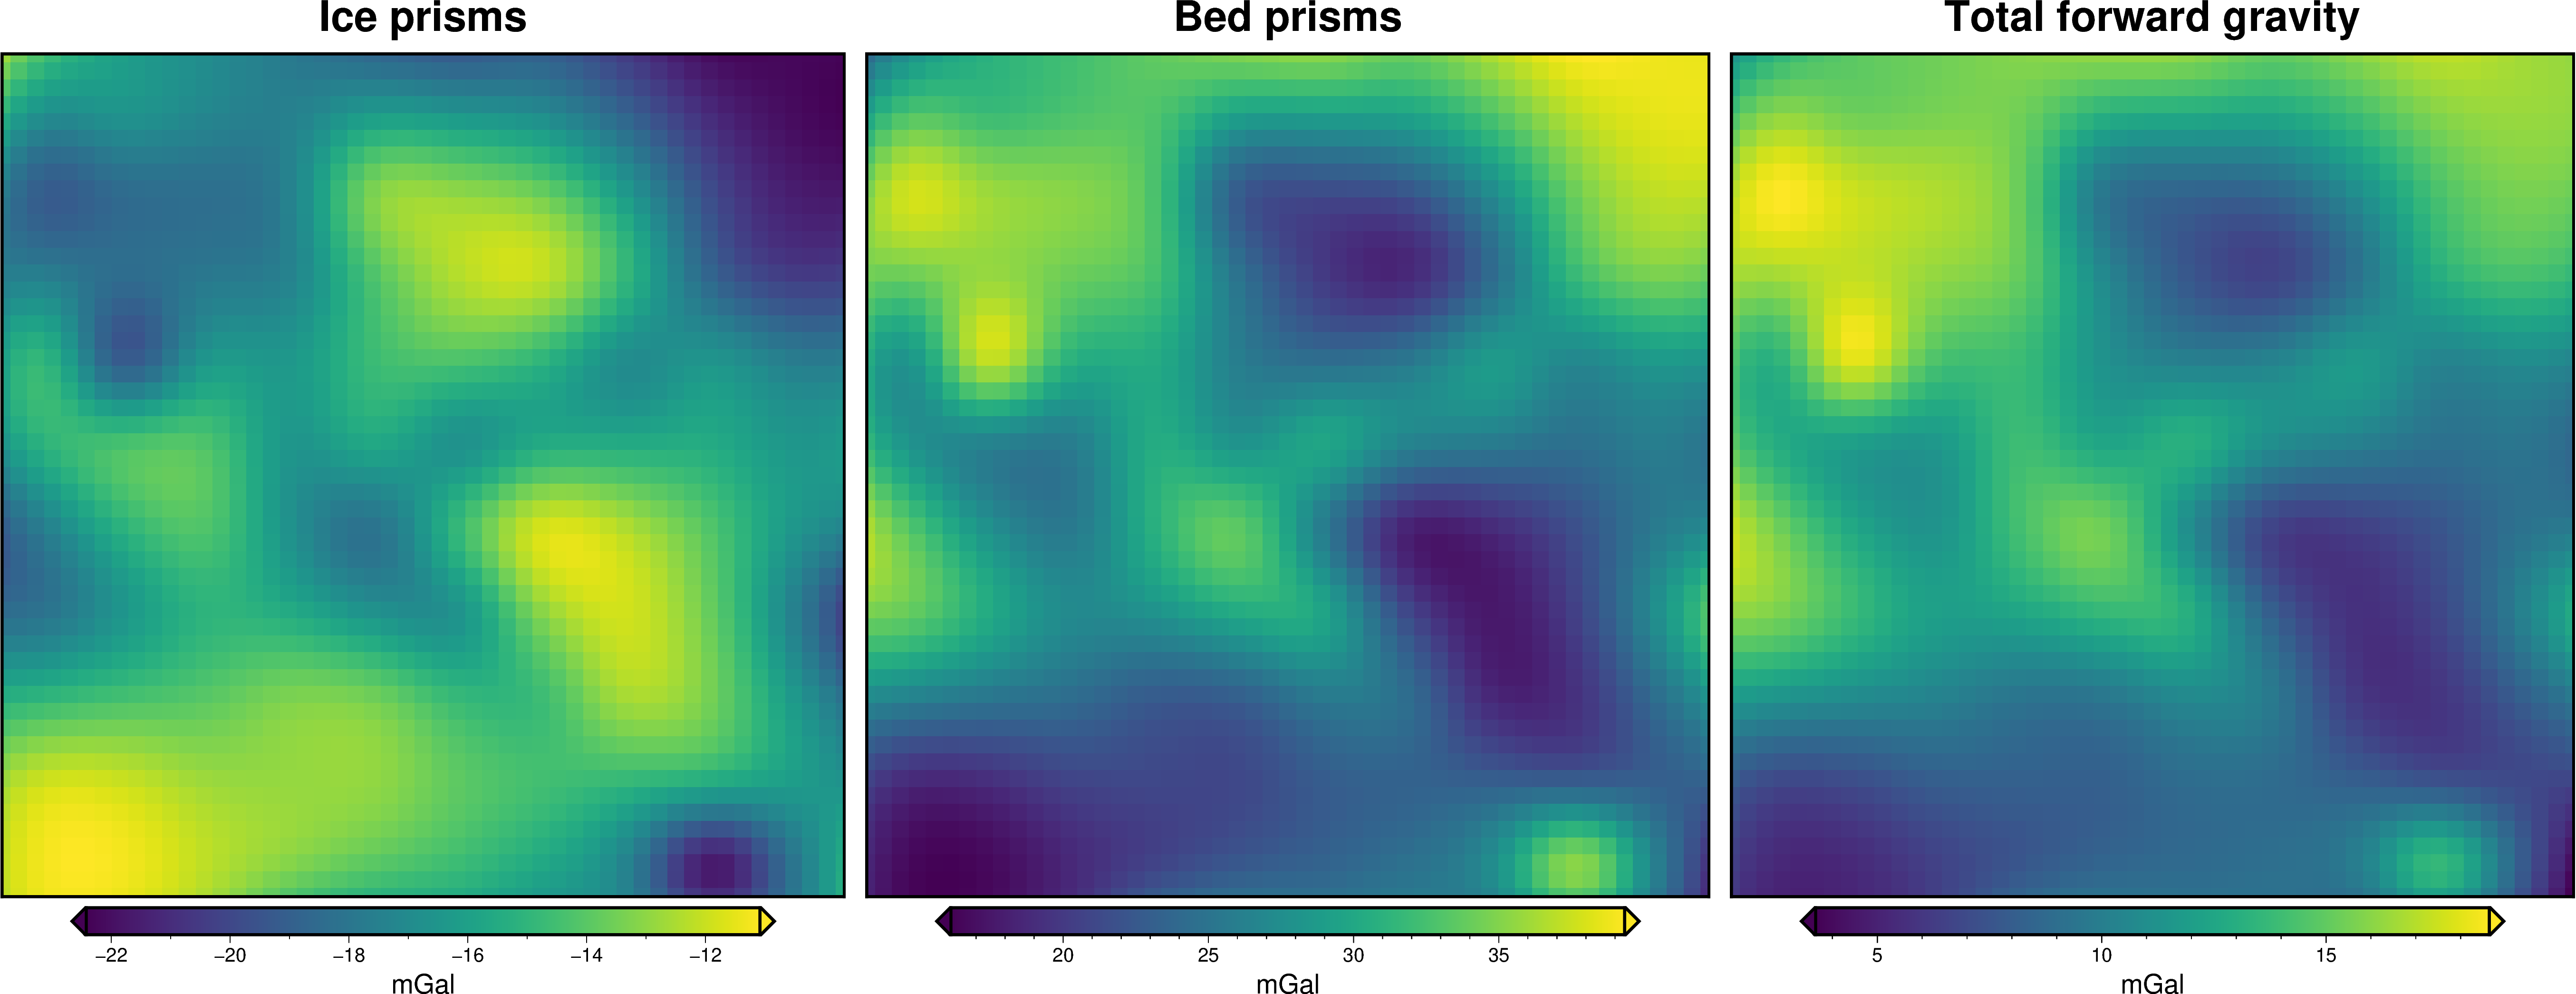

In [19]:
forward_absolute = forward_grav_of_prismlayer(
    [ice_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Bed prisms"],
)

## Density contrasts

In [16]:
above_ice_prisms = grids_to_prisms(
    surface,
    surface.values.max(),
    density=-917,
)

bed_prisms_contrast = grids_to_prisms(
    bed,
    bed.values.min(),
    density=2030 - 917,
)

plotting.show_prism_layers(
    [above_ice_prisms, bed_prisms_contrast],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    clip_box=False,
    zscale=20,
)

ERROR:root:Bad table range: [2.22507e-308, -917]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


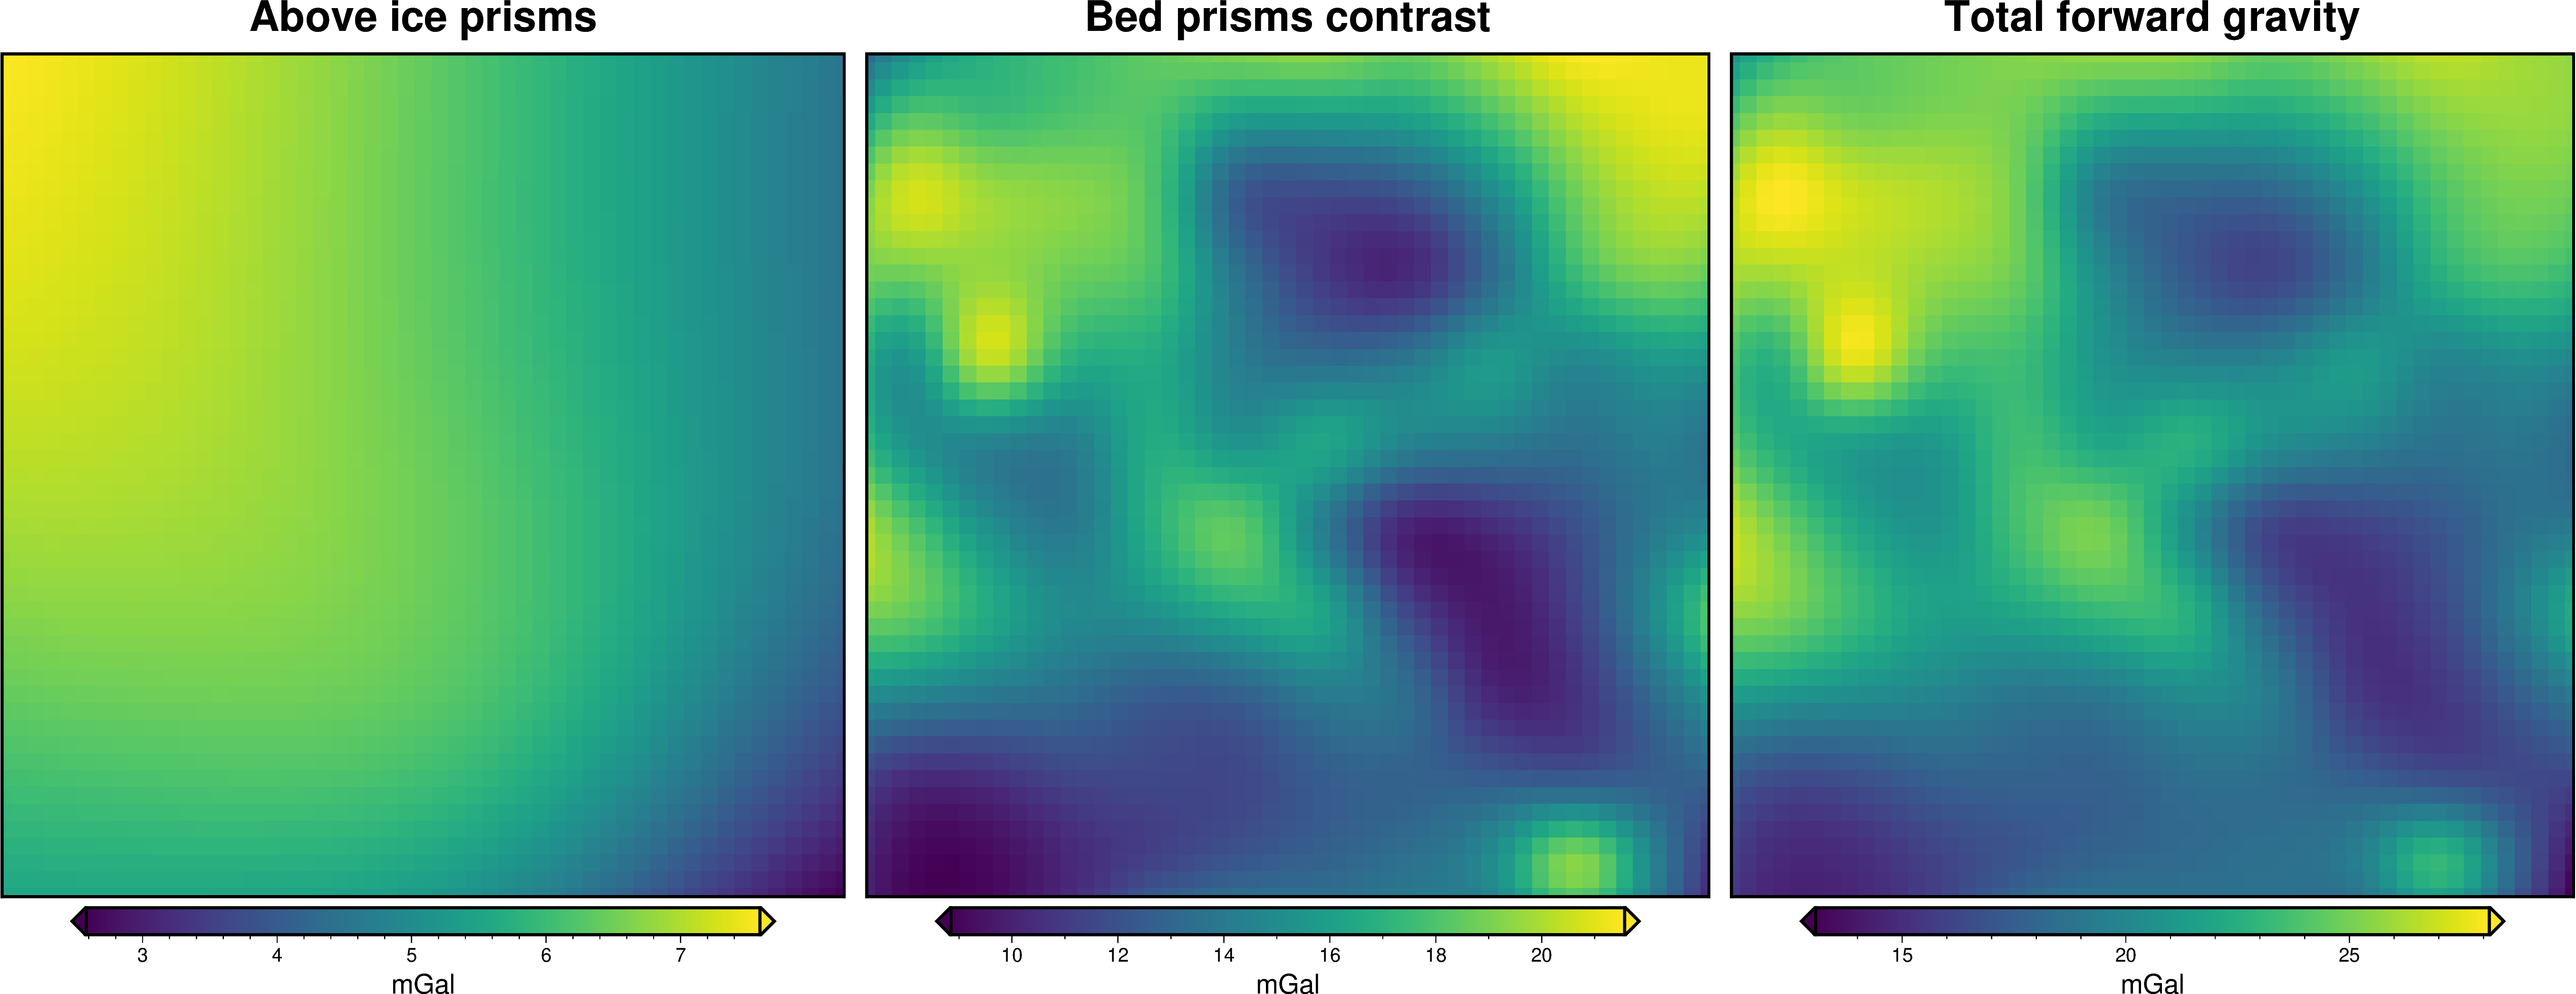

In [29]:
forward_contrasts = forward_grav_of_prismlayer(
    [above_ice_prisms, bed_prisms_contrast],
    observation_points,
    plot=True,
    names=["Above ice prisms", "Bed prisms contrast"],
)

## Compare forward gravities

returning original grid
returning original grid
returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


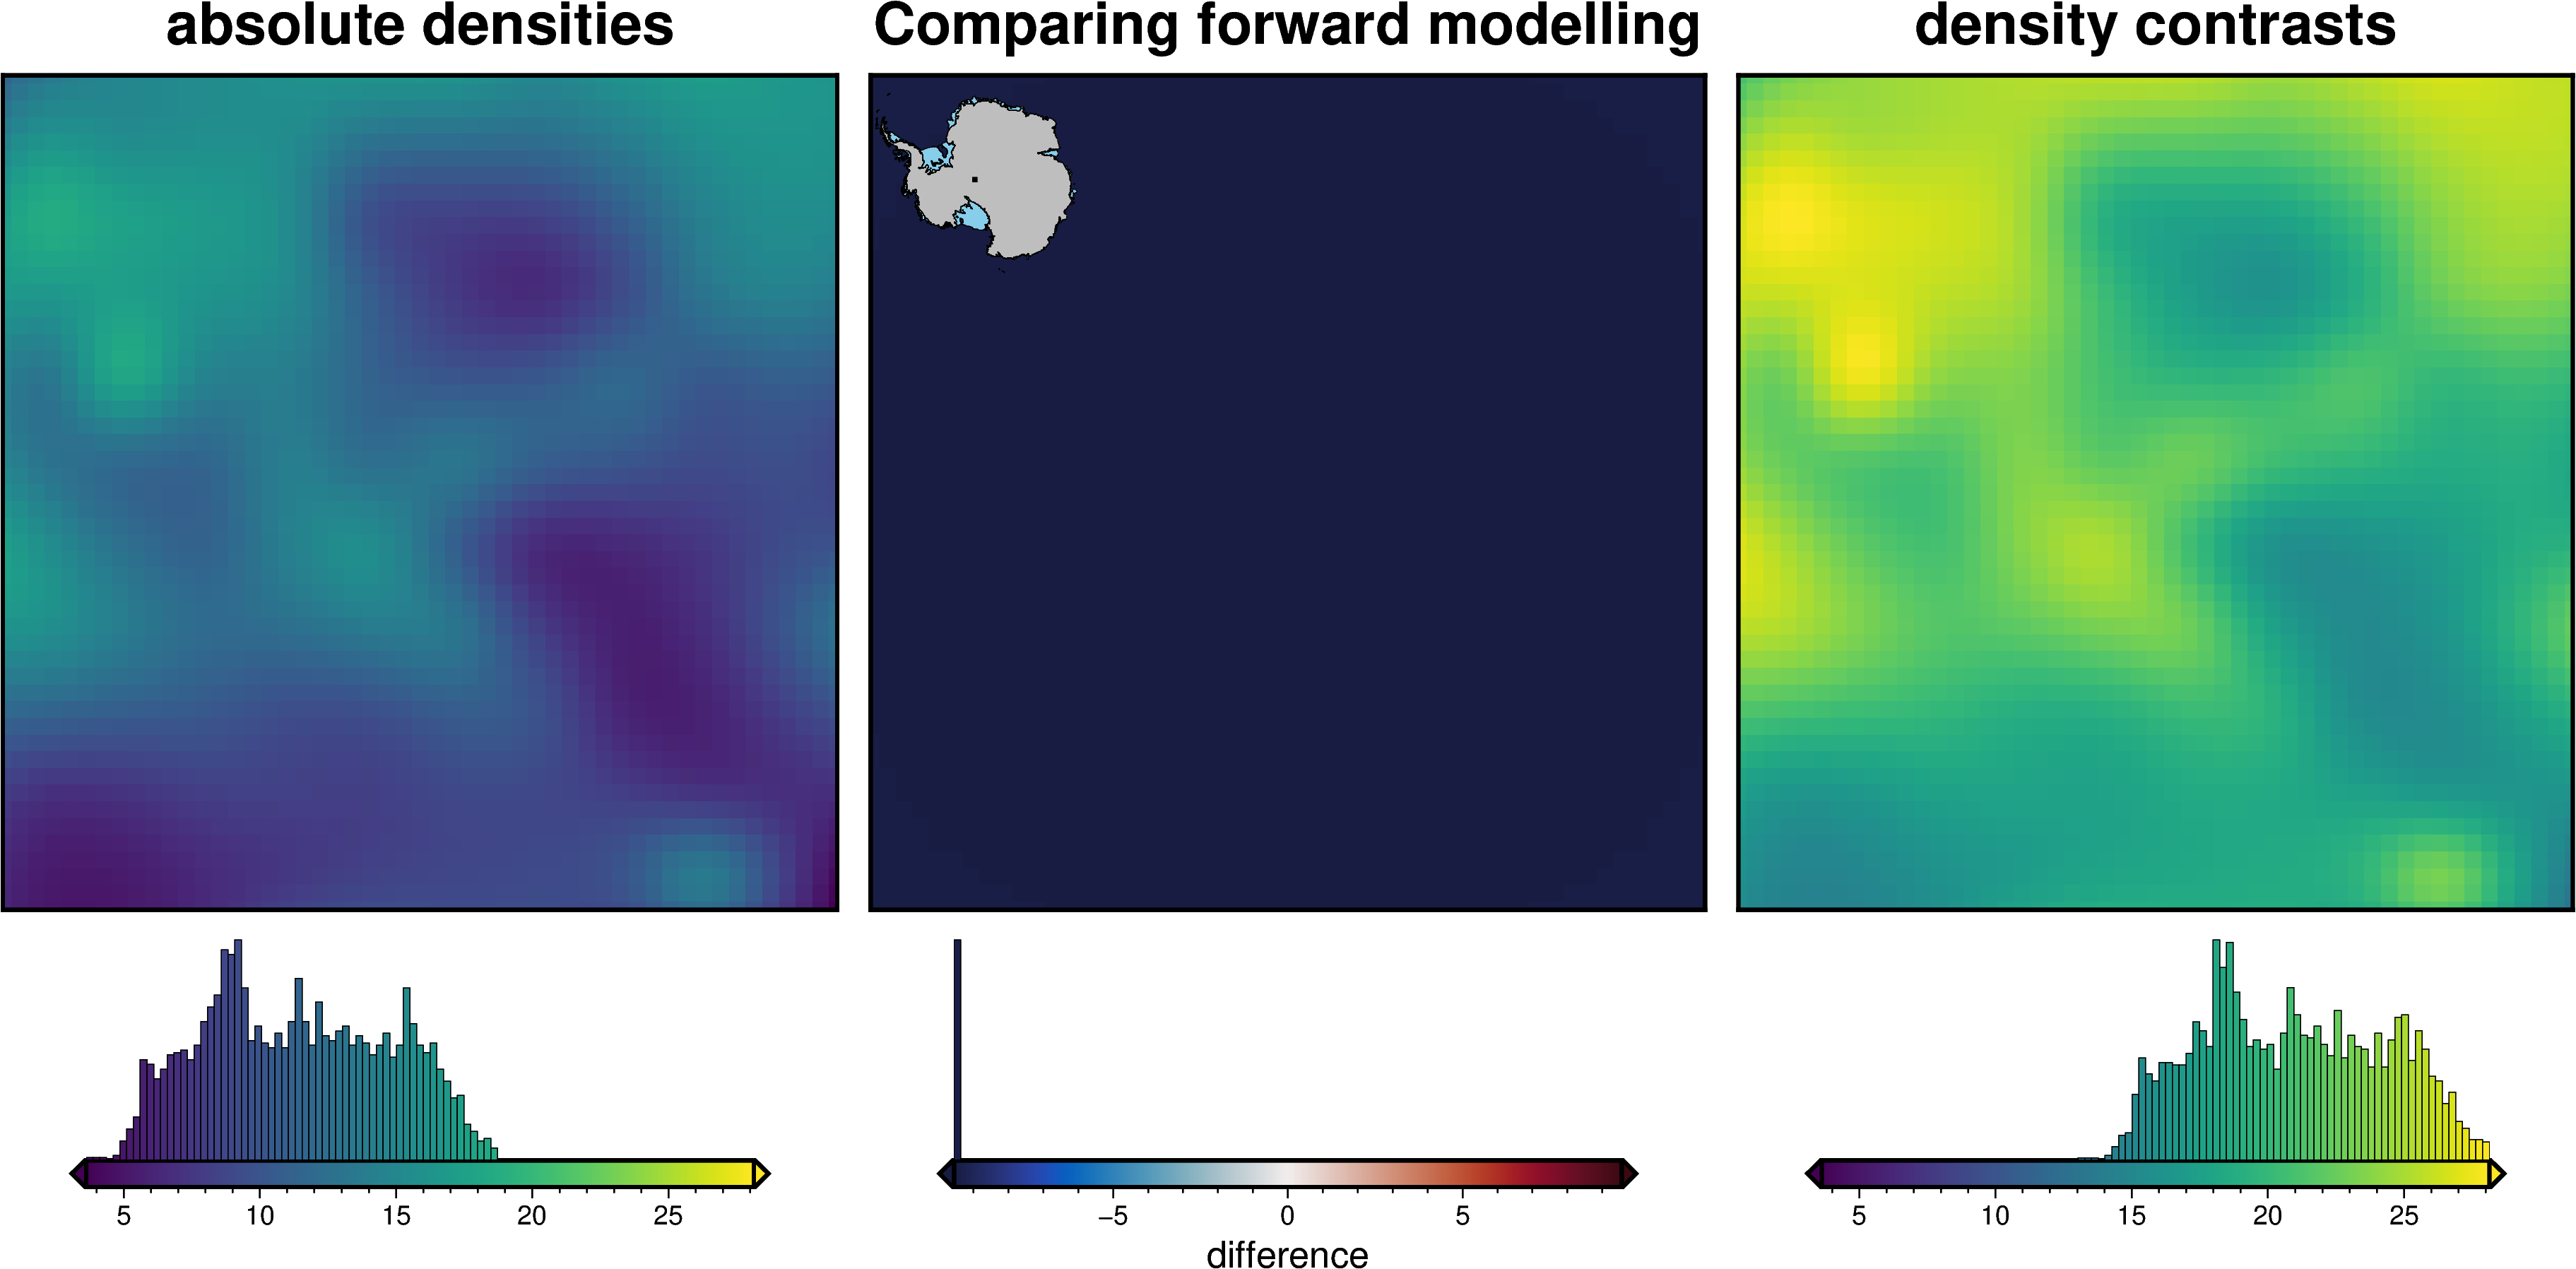

In [30]:
grids = utils.grd_compare(
    forward_absolute[2],
    forward_contrasts[2],
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrasts",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
)

### Normalize then compare

Note that since the upper layer of the density contrasts model is closer to the observation points the overall gravity effect is greater. By normalizing both grids, we can see the difference are minor, less than 1% of the average values (.004/.5 = 0.008 = 0.8%).

In [31]:
norm_forward_absolute = inv_utils.normalize_xarray(
    forward_absolute[2],
)
norm_forward_contrasts = inv_utils.normalize_xarray(
    forward_contrasts[2],
)

returning original grid
returning original grid
returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


returning original grid


ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db
ERROR:fiona._env:PROJ: proj_create_from_database: Cannot find proj.db


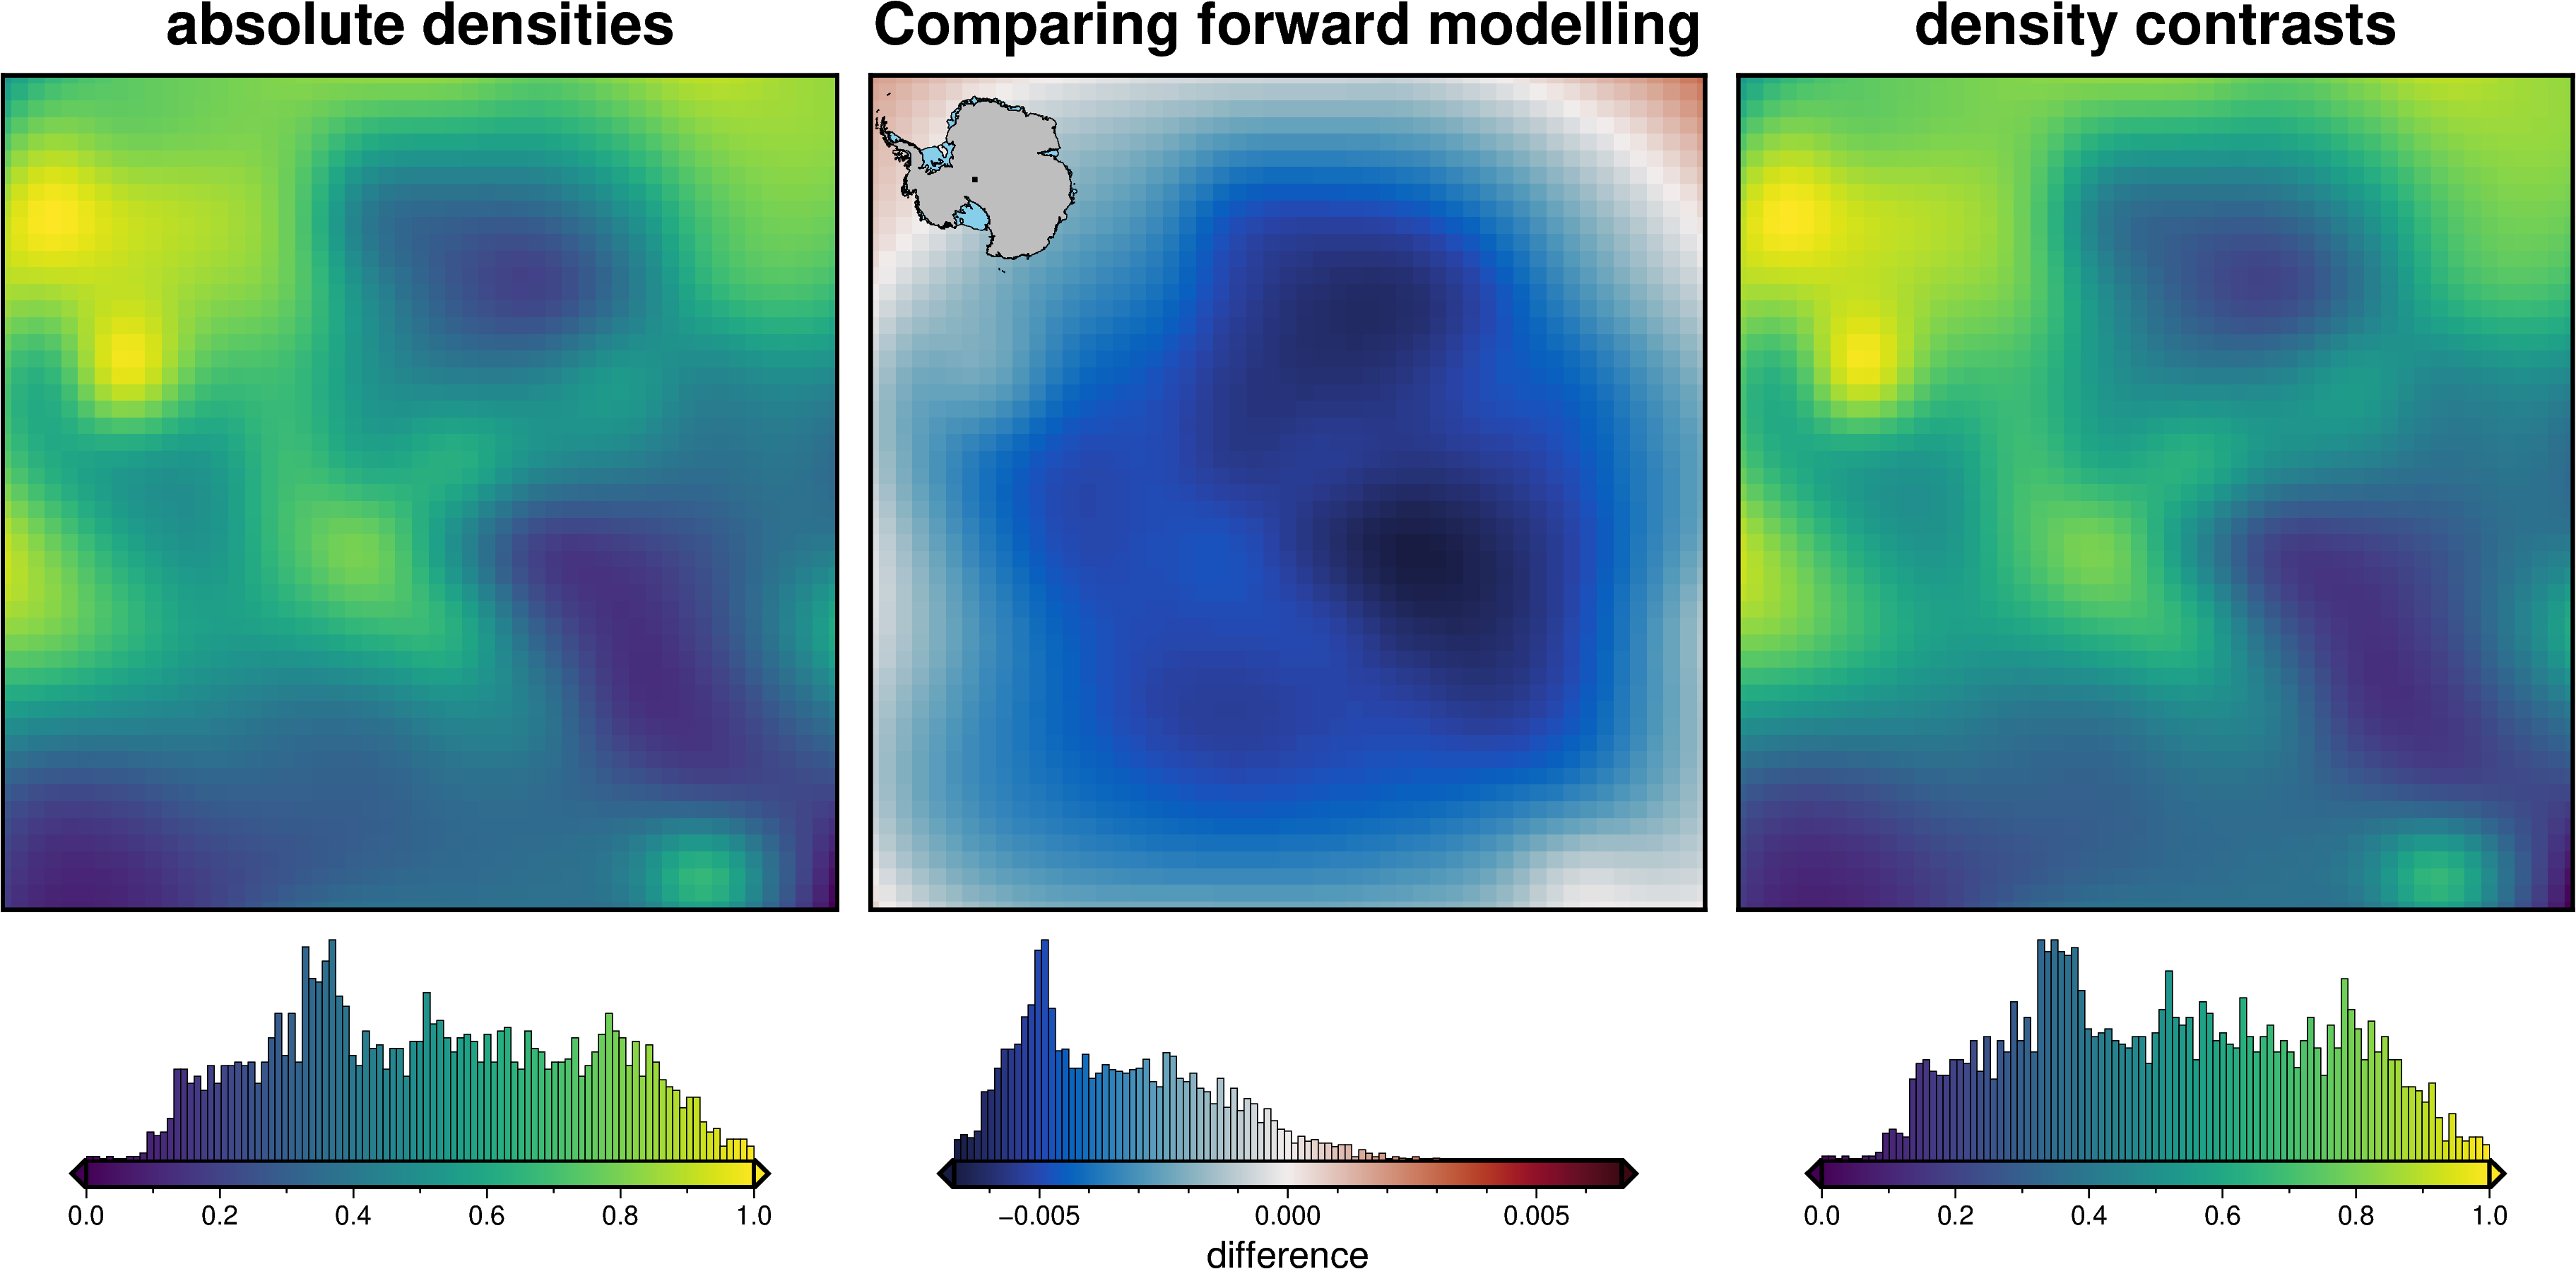

In [32]:
grids = utils.grd_compare(
    norm_forward_absolute,
    norm_forward_contrasts,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrasts",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
)